<a href="https://colab.research.google.com/github/colinkearns/DALI-Application/blob/main/codeSample2/math50_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split  # used to break the model into train and test for overfitting analysis
from scipy.stats import pearsonr # for collinearity analysis
%config InlineBackend.figure_format = "svg"
#from pymc3 import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
alcohol_df = pd.read_csv(r'/content/drive/MyDrive/student_alcohol_consumption.csv')

alcohol_df



,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


In [ ]:
# make a combined Walc and Dalc column
alcohol_df["Talc"] = alcohol_df["Walc"] + alcohol_df["Dalc"] - 1 # subtract one to make it on a scale of 1 to 9

Text(0, 0.5, 'Observed')

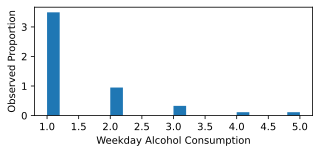

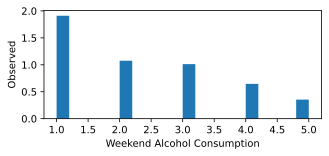

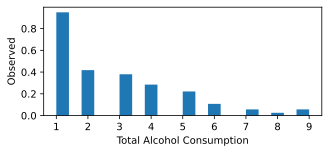

In [ ]:
# histogram of Dalc and Walc and Talc

fig,ax= plt.subplots(figsize=(5,2))
ax.hist(alcohol_df["Dalc"], density=True, bins=20)
ax.set_xlabel("Weekday Alcohol Consumption")
ax.set_ylabel("Observed Proportion")

fig,ax= plt.subplots(figsize=(5,2))
ax.hist(alcohol_df["Walc"], density=True, bins=20)
ax.set_xlabel("Weekend Alcohol Consumption")
ax.set_ylabel("Observed")

fig,ax= plt.subplots(figsize=(5,2))
ax.hist(alcohol_df["Talc"], density=True, bins=20)
ax.set_xlabel("Total Alcohol Consumption")
ax.set_ylabel("Observed")

In [ ]:
# need to first make binary variables 0s and 1s
alcohol_df["school"] = np.select([alcohol_df["school"] == "MS"], [1], default = 0)  # GP is 1
alcohol_df["sex"] = np.select([alcohol_df["sex"] == "M"], [1], default = 0)  # male is 1
alcohol_df["address"] = np.select([alcohol_df["address"] == "U"], [1], default = 0) # urban is 1
alcohol_df["famsize"] = np.select([alcohol_df["famsize"] == "LE3"], [1], default = 0) # less than or equal to 3 is 1
alcohol_df["Pstatus"] = np.select([alcohol_df["Pstatus"] == "T"], [1], default = 0) # parents living together is 1
alcohol_df["school"] = np.select([alcohol_df["school"] == "GP"], [1], default = 0)
# yes/no list
yn_list = ["schoolsup", "famsup", "paid", "activities", "nursery", "higher", "internet", "romantic"]
for col in yn_list:
  alcohol_df[col] = np.select([alcohol_df[col] == "yes"], [1], default = 0)  # yes substituted with 1

alcohol_df


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,Talc
0,0,0,18,1,0,0,4,4,at_home,teacher,...,3,4,1,1,3,6,5,6,6,1
1,0,0,17,1,0,1,1,1,at_home,other,...,3,3,1,1,3,4,5,5,6,1
2,0,0,15,1,1,1,1,1,at_home,other,...,3,2,2,3,3,10,7,8,10,4
3,0,0,15,1,0,1,4,2,health,services,...,2,2,1,1,5,2,15,14,15,1
4,0,0,16,1,0,1,3,3,other,other,...,3,2,1,2,5,4,6,10,10,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,0,1,20,1,1,0,2,2,services,services,...,5,4,4,5,4,11,9,9,9,8
391,0,1,17,1,1,1,3,1,services,services,...,4,5,3,4,2,3,14,16,16,6
392,0,1,21,0,0,1,1,1,other,other,...,5,3,3,3,3,3,10,8,7,5
393,0,1,18,0,1,1,3,2,services,other,...,4,1,3,4,5,0,11,12,10,6


In [ ]:
# using all variables in the data to run a regression model
y_talc = alcohol_df["Talc"]
cols_not_reg = ["school", "reason", "Medu", "Fedu", "Mjob", "Fjob", "guardian", "traveltime", "studytime", "Walc", "Dalc", "Talc"]
df_bigreg = alcohol_df[[col for col in alcohol_df.columns if col not in cols_not_reg]]

# need to generate categorical variables for Medu, Fedu, Mjob, Fjob, guardian, traveltime, studytime
X_medu_dummies = pd.get_dummies(alcohol_df["Medu"],drop_first=True)
X_medu_dummies = X_medu_dummies.add_prefix("medu_")
X_fedu_dummies = pd.get_dummies(alcohol_df["Fedu"],drop_first=True)
X_fedu_dummies = X_fedu_dummies.add_prefix("fedu_")
X_mjob_dummies = pd.get_dummies(alcohol_df["Mjob"],drop_first=True)
X_mjob_dummies = X_mjob_dummies.add_prefix("mjob_")
X_fjob_dummies = pd.get_dummies(alcohol_df["Fjob"],drop_first=True)
X_fjob_dummies = X_fjob_dummies.add_prefix("fjob_")
X_guardian_dummies = pd.get_dummies(alcohol_df["guardian"],drop_first=True)
X_guardian_dummies = X_guardian_dummies.add_prefix("guardian_")
X_tt_dummies = pd.get_dummies(alcohol_df["traveltime"],drop_first=True)
X_tt_dummies = X_tt_dummies.add_prefix("tt_")
X_st_dummies = pd.get_dummies(alcohol_df["studytime"],drop_first=True)
X_st_dummies = X_st_dummies.add_prefix("st_")

# dataframe for regression with all predictors
df_bigreg = pd.concat([df_bigreg, X_medu_dummies, X_fedu_dummies, X_mjob_dummies, X_fjob_dummies,
                      X_guardian_dummies, X_tt_dummies, X_st_dummies], axis=1)
df_bigreg

X_bigreg_numpy = df_bigreg.to_numpy()

# linear regression with all predictors
model_bigreg_alc = sm.OLS(y_talc,sm.add_constant(X_bigreg_numpy))
results_bigreg_alc = model_bigreg_alc.fit()
print(results_bigreg_alc.summary())
r_bigreg_alc = results_bigreg_alc.resid

                            OLS Regression Results                            
Dep. Variable:                   Talc   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     5.780
Date:                Mon, 21 Nov 2022   Prob (F-statistic):           1.09e-22
Time:                        02:39:16   Log-Likelihood:                -718.57
No. Observations:                 395   AIC:                             1531.
Df Residuals:                     348   BIC:                             1718.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5264      2.205     -0.239      0.8

In [ ]:
# finding the interactions that are the statistically significant predictors
stat_sig_list = [1,4,9,11,15,17,19,37,41,43,44,46]
predictor_list = []
for x in stat_sig_list:
  colname = (df_bigreg.iloc[:,[x-1]]).columns
  predictor_list.append(colname)
predictor_list

[Index(['sex'], dtype='object'),
 Index(['famsize'], dtype='object'),
 Index(['paid'], dtype='object'),
 Index(['nursery'], dtype='object'),
 Index(['famrel'], dtype='object'),
 Index(['goout'], dtype='object'),
 Index(['absences'], dtype='object'),
 Index(['fjob_services'], dtype='object'),
 Index(['tt_2'], dtype='object'),
 Index(['tt_4'], dtype='object'),
 Index(['st_2'], dtype='object'),
 Index(['st_4'], dtype='object')]

Text(0, 0.5, 'Predictions')

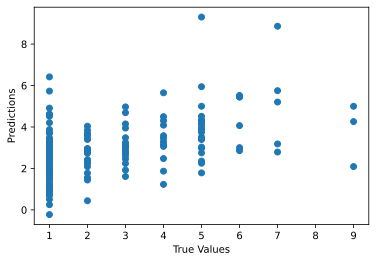

In [ ]:
# examining the predictive power/overfitting of the regression with all predictors

# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(df_bigreg, y_talc, test_size=0.4)

# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

## The line / model
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

# predicted values are fairly good, not overfitted
# R squared does not dictate how predictive the model is, but it does explain how much of the variation in the model
# can be explained by the predictors

In [ ]:
# generate correlation matrix to find Pearson correlation coefficient for all predictors and Talc
results_for_corr = pd.concat([df_bigreg, alcohol_df['Talc']], axis=1)
corr = results_for_corr.corr()
corr

,sex,age,address,famsize,Pstatus,failures,schoolsup,famsup,paid,activities,...,fjob_teacher,guardian_mother,guardian_other,tt_2,tt_3,tt_4,st_2,st_3,st_4,Talc
sex,1.000000,-0.028606,-0.028504,0.089862,0.023443,0.044436,-0.138271,-0.151623,-0.129126,0.099833,...,0.044147,-0.013642,-0.058525,0.015337,0.002412,0.079645,-0.088599,-0.229361,-0.055904,0.298331
age,-0.028606,1.000000,-0.146722,0.037847,0.029598,0.243665,-0.251811,-0.140609,-0.035933,-0.103063,...,-0.069993,-0.133558,0.398396,0.082721,0.059274,-0.036237,0.004577,0.079008,-0.084997,0.134972
address,-0.028504,-0.146722,1.000000,0.072472,-0.042572,-0.078578,0.024712,0.023903,0.052800,-0.051360,...,0.010748,-0.081376,0.025177,-0.139117,-0.230604,-0.138974,0.110868,-0.074150,-0.023743,-0.107599
famsize,0.089862,0.037847,0.072472,1.000000,-0.149612,-0.015769,-0.028642,-0.112893,-0.013882,-0.000113,...,-0.072183,0.026727,-0.025298,0.089500,-0.015222,0.027413,0.110132,-0.162132,0.004596,0.112695
Pstatus,0.023443,0.029598,-0.042572,-0.149612,1.000000,-0.003339,-0.042238,0.019067,0.046435,0.097352,...,-0.063327,-0.065813,-0.051061,0.001986,0.049176,-0.009995,-0.090445,0.061493,0.026397,-0.009808
failures,0.044436,0.243665,-0.078578,-0.015769,-0.003339,1.000000,-0.000437,-0.055075,-0.188039,-0.069341,...,-0.074377,-0.134498,0.291157,0.017204,0.048238,0.080497,-0.035226,-0.061792,-0.108368,0.153203
schoolsup,-0.138271,-0.251811,0.024712,-0.028642,-0.042238,-0.000437,1.000000,0.104681,-0.020753,0.046032,...,0.065294,-0.004054,-0.058982,-0.030837,-0.031261,0.051832,0.066974,-0.048714,0.045293,-0.066207
famsup,-0.151623,-0.140609,0.023903,-0.112893,0.019067,-0.055075,0.104681,1.000000,0.293184,-0.001500,...,0.064417,-0.014124,0.007522,-0.053259,0.042363,0.003643,0.069573,0.044532,0.071218,-0.070435
paid,-0.129126,-0.035933,0.052800,-0.013882,0.046435,-0.188039,-0.020753,0.293184,1.000000,-0.021382,...,-0.064065,0.064926,-0.012352,0.056818,-0.098491,-0.060087,0.084050,0.057764,0.073046,0.067274
activities,0.099833,-0.103063,-0.051360,-0.000113,0.097352,-0.069341,0.046032,-0.001500,-0.021382,1.000000,...,-0.014697,0.022809,-0.042382,0.006289,-0.015220,-0.002548,0.022744,0.039936,0.045368,-0.054177


In [ ]:
# check for collinearity between predictors
collinear_list = []
for column in corr.columns:
    for index in corr.index:
      if (corr[column][index] > 0.5) and ((index+"_"+column) not in collinear_list) and (column != index):
        collinear_list.append((column+"_"+index))

print(collinear_list)

# the variables that are collinear are not being used in the regression because they are not statistically significant predictors

['G1_G2', 'G1_G3', 'G2_G3', 'medu_4_mjob_teacher']


In [ ]:
# find the variables that are most highly correlated with Talc
correlation_list = []

for column in corr.columns:
    col_df = corr[column].copy()
    col_df = col_df.reset_index()
    corr_tuple_list = [tuple(r) for r in col_df.to_numpy()]
    for ctuple in corr_tuple_list:
        if ctuple[1] >= 0.1 and ctuple[0] != column and [ctuple[0], column, ctuple[1]] not in correlation_list and ((ctuple[0] == "Talc") | (column == "Talc")):
            correlation_list.append([column, ctuple[0], ctuple[1]])

print("These are the variables that are most highly correlated with total alcohol consumption in students:")        
correlation_list

These are the variables that are most highly correlated with total alcohol consumption in students:


[['sex', 'Talc', 0.29833067512276157],
 ['age', 'Talc', 0.13497227369510933],
 ['famsize', 'Talc', 0.11269457042591866],
 ['failures', 'Talc', 0.15320332600501796],
 ['freetime', 'Talc', 0.18975354724025556],
 ['goout', 'Talc', 0.3926829381591808],
 ['absences', 'Talc', 0.13868747915571572],
 ['fjob_services', 'Talc', 0.10881810833001973],
 ['tt_4', 'Talc', 0.225099002275779]]

In [ ]:
# another method of determining if there are any collinear predictors

for col1 in df_bigreg.columns:
  for col2 in df_bigreg.columns:
    if col1 != col2:
      corr,__ = pearsonr(df_bigreg[col1],df_bigreg[col2])
      if corr > 0.7:
        print(col1)
        print(col2)
        print("Pearson's correlation: ", corr)

G1
G2
Pearson's correlation:  0.8521180663648062
G1
G3
Pearson's correlation:  0.8014679320174141
G2
G1
Pearson's correlation:  0.8521180663648062
G2
G3
Pearson's correlation:  0.9048679892693011
G3
G1
Pearson's correlation:  0.8014679320174141
G3
G2
Pearson's correlation:  0.9048679892693011


In [ ]:
# from correlation matrix and preliminary regression using all variables
# using sex, age, famsize, traveltime, failures, freetime, goout, paid, nursery, famrel, fjob, and absences to predict alcohol consumption

list_maincorr = ["sex", "age", "famsize", "failures", "absences", "freetime", "goout", "paid", "nursery", "famrel"]
# traveltime is categorical
# goout and freetime are ranked on scales; they are nominal and ordered
# thus use the assumption to treat them as continuous variables (this assumption is tested later on)

# create dataframe containing all statistically significant predictors
df_maincorr_noint = alcohol_df[list_maincorr]
df_maincorr_noint = pd.concat([df_maincorr_noint, X_tt_dummies, X_fjob_dummies], axis=1)
df_maincorr_noint

X_maincorr_noint_numpy = df_maincorr_noint.to_numpy()

# linear regression with all statistically significant predictors
model_maincorr_noint_alc = sm.OLS(y_talc,sm.add_constant(X_maincorr_noint_numpy))
results_maincorr_noint_alc = model_maincorr_noint_alc.fit()
print(results_maincorr_noint_alc.summary())
r_maincorr_noint_alc = results_maincorr_noint_alc.resid

df_maincorr_noint

                            OLS Regression Results                            
Dep. Variable:                   Talc   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     13.20
Date:                Mon, 21 Nov 2022   Prob (F-statistic):           3.86e-29
Time:                        02:39:57   Log-Likelihood:                -738.47
No. Observations:                 395   AIC:                             1513.
Df Residuals:                     377   BIC:                             1585.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9901      1.278     -0.775      0.4

,sex,age,famsize,failures,absences,freetime,goout,paid,nursery,famrel,tt_2,tt_3,tt_4,fjob_health,fjob_other,fjob_services,fjob_teacher
0,0,18,0,0,6,3,4,0,1,4,1,0,0,0,0,0,1
1,0,17,0,0,4,3,3,0,0,5,0,0,0,0,1,0,0
2,0,15,1,3,10,3,2,1,1,4,0,0,0,0,1,0,0
3,0,15,0,0,2,2,2,1,1,3,0,0,0,0,0,1,0
4,0,16,0,0,4,3,2,1,1,4,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,1,20,1,2,11,5,4,1,1,5,0,0,0,0,0,1,0
391,1,17,1,0,3,4,5,0,0,2,1,0,0,0,0,1,0
392,1,21,0,3,3,5,3,0,0,5,0,0,0,0,1,0,0
393,1,18,1,0,0,4,1,0,0,4,0,1,0,0,1,0,0


Text(0.5, 0, 'residual')

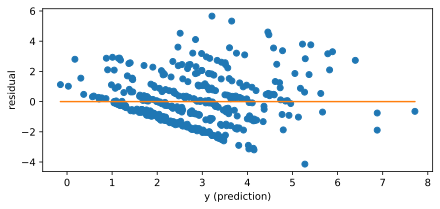

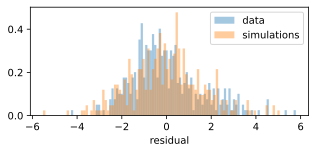

In [ ]:
# graph residual plots, residuals versus predicted value

y_mean_pred_maincorr_noint_alc = y_talc-r_maincorr_noint_alc

fig,ax = plt.subplots(figsize=(7,3))
ax.plot(y_mean_pred_maincorr_noint_alc,(r_maincorr_noint_alc + np.random.normal(0,0.1,len(r_maincorr_noint_alc))),"o") # add jitter for visualization
ax.plot(y_mean_pred_maincorr_noint_alc,np.zeros(len(y_talc)),"-")
ax.set_xlabel("y (prediction)")
ax.set_ylabel("residual")
# finding larger or smaller residual values DOES appear to depend upon Y...slightly more negative residuals as predicted alcohol 
# consumption increases

# graphing histogram of residuals to see if they are normally distributed
r_sims_maincorr_noint_alc = np.random.normal(0,np.sqrt(results_maincorr_noint_alc.mse_resid),len(r_maincorr_noint_alc))
fig,ax = plt.subplots(figsize=(5,2))
ax.hist(r_maincorr_noint_alc,100,alpha=0.4,label="data",density=True);
ax.hist(r_sims_maincorr_noint_alc,100,alpha=0.4,label="simulations",density=True);
ax.legend()
ax.set_xlabel("residual")
# the residuals are fairly normally distributed; can see that this distribution appears similar to the residual 
# histogram that is generated from the simulated normal model

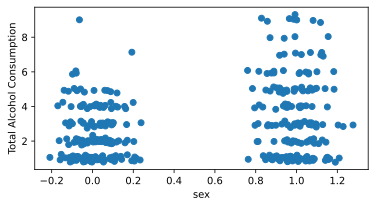

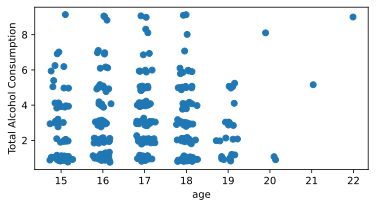

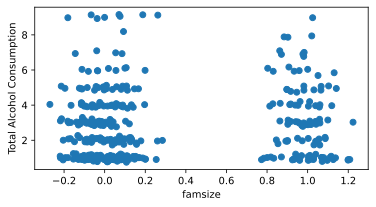

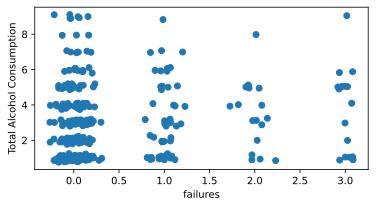

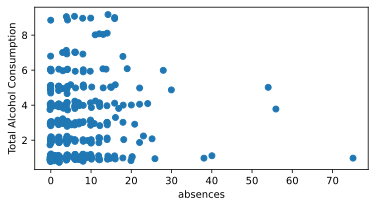

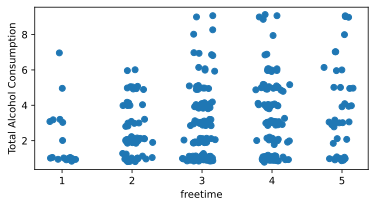

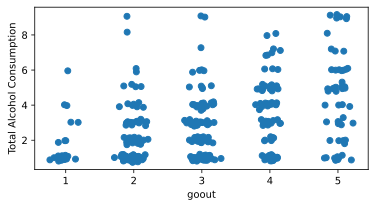

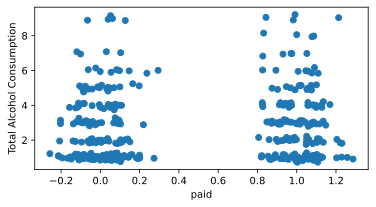

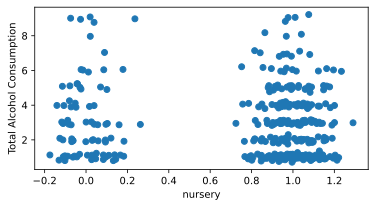

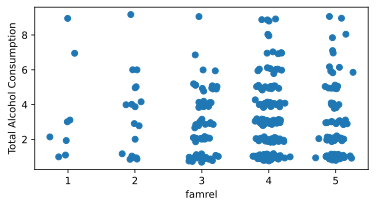

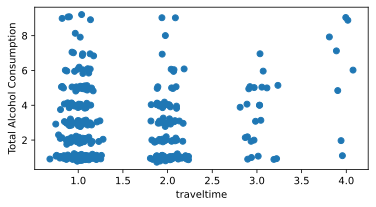

In [ ]:
# graph each variable individually to explore univariate correlations 

for var in list_maincorr+["traveltime"]:
  fig,ax = plt.subplots(figsize=(6,3))
  ax.plot((alcohol_df[var] + np.random.normal(0,0.1,len(alcohol_df[var]))),
          (alcohol_df["Talc"] + np.random.normal(0,0.1,len(alcohol_df["Talc"]))),"o") # add jitter for visualization
  ax.set_xlabel(var)
  ax.set_ylabel("Total Alcohol Consumption")


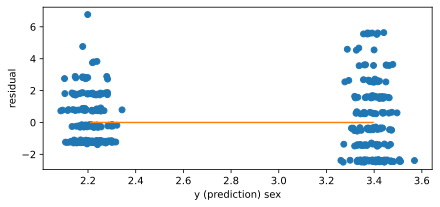

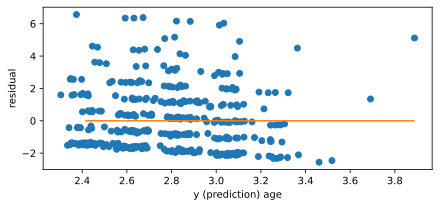

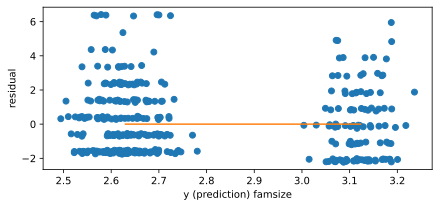

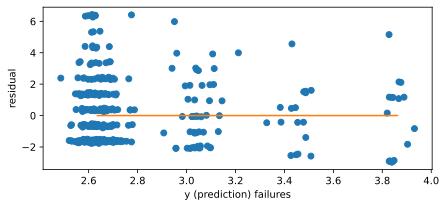

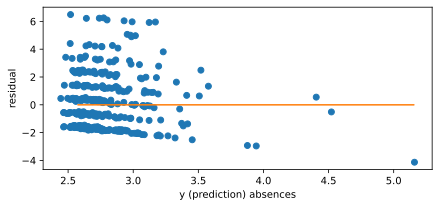

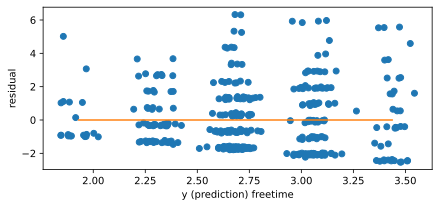

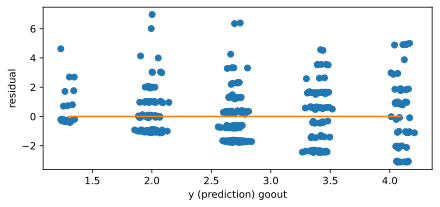

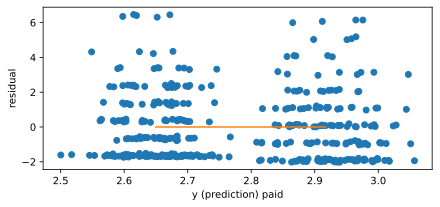

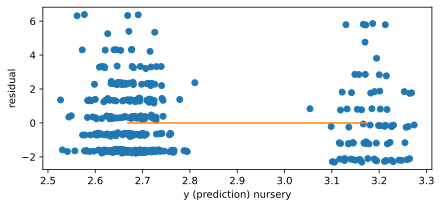

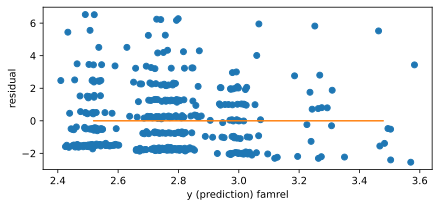

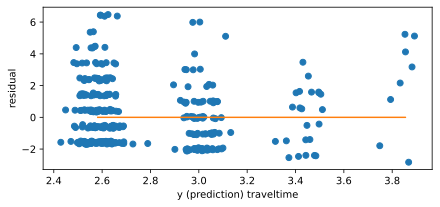

In [ ]:
# graph residual plots for each variable to determine if features should be added
list_all = ["sex", "age", "famsize", "failures", "absences", "freetime", "goout", "paid", "nursery", "famrel", "traveltime"]

for var in list_all:

  X = alcohol_df[var].to_numpy()

  univar_model = sm.OLS(y_talc,sm.add_constant(X))
  univar_results = univar_model.fit()
  # print(univar_results.summary())
  r_univar = univar_results.resid

  y_mean_pred_univar = y_talc-r_univar

  fig,ax = plt.subplots(figsize=(7,3))
  ax.plot((y_mean_pred_univar+ np.random.normal(0,0.05,len(r_univar))),
          (r_univar+ np.random.normal(0,0.05,len(r_univar))),"o") # add jitter for visualization
  ax.plot(y_mean_pred_univar,np.zeros(len(y_talc)),"-")
  ax.set_xlabel(("y (prediction) "+var))
  ax.set_ylabel("residual")

In [ ]:
# testing the same model (with the 12 predictors) with a logarithmic response variable, testing for logarithmic relationship

x_log = df_maincorr_noint.to_numpy()
y_log = np.log(alcohol_df["Talc"].to_numpy())
X_log = sm.add_constant(x_log) # add a column of all 1s
model_maincorr_noint_log = sm.OLS(y_log,X_log)
results_maincorr_noint_log = model_maincorr_noint_log.fit()
print(results_maincorr_noint_log.summary())
r_maincorr_noint_log = results_maincorr_noint_log.resid

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     11.07
Date:                Mon, 21 Nov 2022   Prob (F-statistic):           2.00e-24
Time:                        02:41:06   Log-Likelihood:                -339.01
No. Observations:                 395   AIC:                             714.0
Df Residuals:                     377   BIC:                             785.6
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5896      0.465     -1.268      0.2

Text(0.5, 0, 'residual')

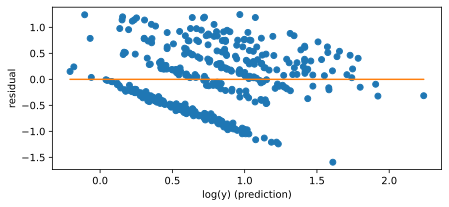

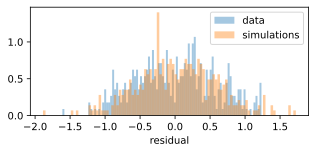

In [ ]:
# plot residuals vs predicted for log(y) regression

y_mean_pred_maincorr_noint_log = y_log-r_maincorr_noint_log

fig,ax = plt.subplots(figsize=(7,3))
ax.plot(y_mean_pred_maincorr_noint_log,(r_maincorr_noint_log + np.random.normal(0,0.04,len(r_maincorr_noint_log))),"o") # add jitter for visualization
# reduced the magnitude of the jitter because the scale decreases when taking the log
ax.plot(y_mean_pred_maincorr_noint_log,np.zeros(len(y_talc)),"-")
ax.set_xlabel("log(y) (prediction)")
ax.set_ylabel("residual")
# finding larger or smaller residual values DOES appear to depend upon Y...slightly more negative residuals as predicted alcohol 
# consumption increases

# graphing histogram of residuals to see if they are normally distributed
r_sims_maincorr_noint_log = np.random.normal(0,np.sqrt(results_maincorr_noint_log.mse_resid),len(r_maincorr_noint_log))
fig,ax = plt.subplots(figsize=(5,2))
ax.hist(r_maincorr_noint_log,100,alpha=0.4,label="data",density=True);
ax.hist(r_sims_maincorr_noint_log,100,alpha=0.4,label="simulations",density=True);
ax.legend()
ax.set_xlabel("residual")
# the residuals ARE normally distributed; can see that this distribution appears similar to the residual 
# histogram that is generated from the simulated normal model

In [ ]:
# generating a dataframe containing interaction terms between all of the 12 main predictors

df_maincorr_int = alcohol_df[list_maincorr]
df_maincorr_int = pd.concat([df_maincorr_int, X_tt_dummies, X_fjob_dummies], axis=1)

cols = df_maincorr_int.columns # list of names of the different predictors

for i in range(len(cols)):
  for j in range(len(cols))[i+1:]:  # only look for interactions that are in front of the predictor in the list to avoid getting duplicates
    c1 = cols[i]
    c2 = cols[j]
    # print(c1,c2)
    if str(c1)[:-2] != str(c2)[:-2]:  # make sure that they are not BOTH traveltime, freetime, or goout variables
      # print(df_maincorr_int[c1].values)x
      # print(df_maincorr_int[c2].values)
      df_maincorr_int[c1+"-"+c2] = df_maincorr_int[c1].values*df_maincorr_int[c2].values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  app.launch_new_instance()


In [ ]:
df_maincorr_int

,sex,age,famsize,failures,absences,freetime,goout,paid,nursery,famrel,...,tt_4-fjob_health,tt_4-fjob_other,tt_4-fjob_services,tt_4-fjob_teacher,fjob_health-fjob_other,fjob_health-fjob_services,fjob_health-fjob_teacher,fjob_other-fjob_services,fjob_other-fjob_teacher,fjob_services-fjob_teacher
0,0,18,0,0,6,3,4,0,1,4,...,0,0,0,0,0,0,0,0,0,0
1,0,17,0,0,4,3,3,0,0,5,...,0,0,0,0,0,0,0,0,0,0
2,0,15,1,3,10,3,2,1,1,4,...,0,0,0,0,0,0,0,0,0,0
3,0,15,0,0,2,2,2,1,1,3,...,0,0,0,0,0,0,0,0,0,0
4,0,16,0,0,4,3,2,1,1,4,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,1,20,1,2,11,5,4,1,1,5,...,0,0,0,0,0,0,0,0,0,0
391,1,17,1,0,3,4,5,0,0,2,...,0,0,0,0,0,0,0,0,0,0
392,1,21,0,3,3,5,3,0,0,5,...,0,0,0,0,0,0,0,0,0,0
393,1,18,1,0,0,4,1,0,0,4,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# run regression using the interaction terms

x = df_maincorr_int.to_numpy()
y = alcohol_df["Talc"].to_numpy()
X = sm.add_constant(x) # add a column of all 1s
model_maincorr_int = sm.OLS(y,X)
results_maincorr_int = model_maincorr_int.fit()
print(results_maincorr_int.summary())
r_maincorr_int = results_maincorr_int.resid

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     3.044
Date:                Mon, 21 Nov 2022   Prob (F-statistic):           7.69e-15
Time:                        02:41:32   Log-Likelihood:                -641.61
No. Observations:                 395   AIC:                             1557.
Df Residuals:                     258   BIC:                             2102.
Df Model:                         136                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.5634     13.106     -0.501      0.6

Text(0.5, 0, 'residual')

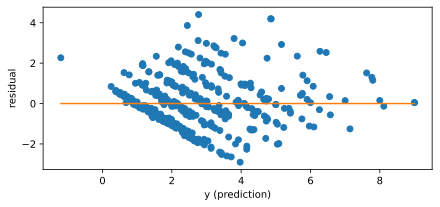

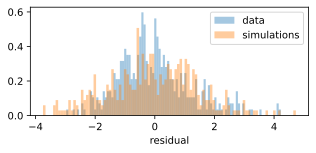

In [ ]:
# plot residuals vs predicted for regression including all interaction terms

y_mean_pred_maincorr_int = y_talc-r_maincorr_int

fig,ax = plt.subplots(figsize=(7,3))
ax.plot(y_mean_pred_maincorr_int,(r_maincorr_int + np.random.normal(0,0.1,len(r_maincorr_int))),"o") # add jitter for visualization
ax.plot(y_mean_pred_maincorr_int,np.zeros(len(y_talc)),"-")
ax.set_xlabel("y (prediction)")
ax.set_ylabel("residual")
# finding larger or smaller residual values DOES appear to depend upon Y...slightly more negative residuals as predicted alcohol 
# consumption increases

# graphing histogram of residuals to see if they are normally distributed
r_sims_maincorr_int = np.random.normal(0,np.sqrt(results_maincorr_int.mse_resid),len(r_maincorr_int))
fig,ax = plt.subplots(figsize=(5,2))
ax.hist(r_maincorr_int,100,alpha=0.4,label="data",density=True);
ax.hist(r_sims_maincorr_int,100,alpha=0.4,label="simulations",density=True);
ax.legend()
ax.set_xlabel("residual")
# the residuals ARE normally distributed; can see that this distribution appears similar to the residual 
# histogram that is generated from the simulated normal model

Text(0, 0.5, 'Predictions')

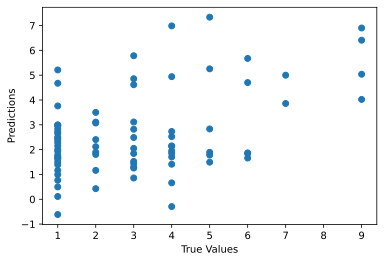

In [ ]:
# examining the predictive power of the 12 variable regression with all interaction terms (150 predictors total)

y = alcohol_df["Talc"] # define the target variable (dependent variable) as y

# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(df_maincorr_int, y, test_size=0.2)

# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

## The line / model
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

# this is overfit, the predictions on the test set are not good

In [ ]:
# find the statistically significant interaction terms
stat_sig_list = [18,23,36,43,45,76,79,81,83,84,114,118,119,122]
predictor_list = []
for x in stat_sig_list:
  colname = (df_maincorr_int.iloc[:,[x-1]]).columns
  predictor_list.append(colname)
predictor_list

[Index(['sex-age'], dtype='object'),
 Index(['sex-goout'], dtype='object'),
 Index(['age-absences'], dtype='object'),
 Index(['age-tt_3'], dtype='object'),
 Index(['age-fjob_health'], dtype='object'),
 Index(['absences-freetime'], dtype='object'),
 Index(['absences-nursery'], dtype='object'),
 Index(['absences-tt_2'], dtype='object'),
 Index(['absences-tt_4'], dtype='object'),
 Index(['absences-fjob_health'], dtype='object'),
 Index(['paid-fjob_health'], dtype='object'),
 Index(['nursery-famrel'], dtype='object'),
 Index(['nursery-tt_2'], dtype='object'),
 Index(['nursery-fjob_health'], dtype='object')]

Analyzing potential overfitting in the regression containing all variables

395


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'coefficient')

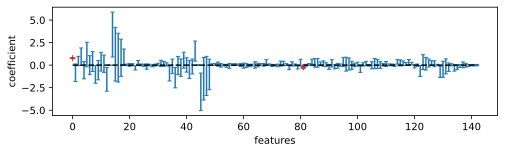

In [ ]:
X = np.array(df_maincorr_int.to_numpy())
std_X = np.std(X,axis=0)
X = (X-np.mean(X,axis=0))/np.std(X,axis=0) # standardize the predictors
X = sm.add_constant(X)
# remove columns with Nan that couldn't be standardized
X = np.delete(X, 137, 1)
X = np.delete(X, 140, 1)
X = np.delete(X, 143, 1)
X = np.delete(X, 143, 1)
X = np.delete(X, 143, 1)
X = np.delete(X, 143, 1)
X = np.delete(X, 143, 1)
X = np.delete(X, 143, 1)
# 145-150, 141, 137 --> columns with Nan

# prep x and y
ey = alcohol_df.Talc
y = np.log(ey[ey>0])
X = X[ey>0]
model = sm.OLS(y,X)
results = model.fit()
print(len(y))

# extract the coefficients and sort them
A = results.params
A_err = results.bse
#A_err = np.array([x for _, x in sorted(zip(A, A_err))])
##A = np.sort(A)

fig,ax = plt.subplots(figsize=(8,2))
ax.errorbar(range(len(A)),A,yerr=1.6*A_err,linestyle="none",marker="",capsize=2.)

inds_ss = np.array(range(len(A)))[results.pvalues.values<0.005]
# plotting significant coefficients
# the plotting function errorbar(x,y,yerr=err) plots x vs. y along with error bars of width err
# capsize sets how wide the horizontal lines on top are
ax.errorbar(np.array(range(len(A)))[inds_ss],A[inds_ss],yerr=1.6*A_err[inds_ss],linestyle="none",marker="+",capsize=2.,color="C3")

ax.plot(range(len(A)),np.zeros(len(A)),"k--")
# plot how many feautres are accounted for by coefficients (and error bars) --> left skewed
# largely 20-40 are accounted for by significant coefficients
ax.set_xlabel("features")
ax.set_ylabel("coefficient")

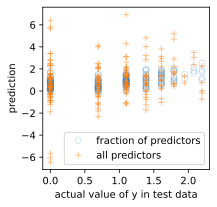

In [ ]:
# take a fraction of the predictors out and test/train

num_train = 200
X_new = X[:,:20]
X_train = X_new[:num_train]
X_test = X_new[num_train:]
y_train = y[:num_train]
y_test = y[num_train:]

model = sm.OLS(y_train,X_train)
results = model.fit()
A = results.params

y_hat = np.dot(X_test,A)

# test/train with all the predictors
X_new = X
X_train = X_new[:num_train]
X_test = X_new[num_train:]
y_train = y[:num_train]
y_test = y[num_train:]

model = sm.OLS(y_train,X_train)
results = model.fit()
A = results.params

y_hat2 = np.dot(X_test,A)

# plot predcted vs actual values
fig,ax = plt.subplots(figsize=(3,3))
ax.plot(y_test,y_hat,"o", label="fraction of predictors",fillstyle="none",alpha=0.2)
ax.plot(y_test,y_hat2,"+",label="all predictors",alpha=0.5)
ax.set_xlabel("actual value of y in test data")
ax.set_ylabel("prediction")
ax.legend()

# it is overfit because many of the tested values for a fraction of the predictors are not accurate when the model generated using the
# training set is applied. Although R squared is high for the model, this happens simply because the model is increasing in dimensionality
# but the lack of accuracy in predicting alcohol consumption for unseen data points is very poor. 

In [ ]:
# regression model including the most statistically significant predictors and interaction terms
# if we decided to include interaction terms, this would be the model we would use

# add interaction terms with continuous/binary variables
sex_age = pd.DataFrame((alcohol_df["sex"].values * alcohol_df["age"].values), columns=["sex-age"])
sex_goout = pd.DataFrame((alcohol_df["sex"].values * alcohol_df["goout"].values), columns=["sex-goout"])

# generate dataframes that contain interactions between continuous/binary variables and categorical variables
abs_traveltime = pd.DataFrame()
for x in X_tt_dummies.columns:
  abs_traveltime[x+"-absences"] = X_tt_dummies[x].values*alcohol_df["absences"].values
nursery_traveltime = pd.DataFrame()
for x in X_tt_dummies.columns:
  nursery_traveltime[x+"-nursery"] = X_tt_dummies[x].values*alcohol_df["nursery"].values

final_predictors = ["sex", "famsize", "goout", "famrel"]
# traveltime, sex-goout, tt-absences, sex-age, tt-nursery are also statistically significant and should be added to the model
final_reg_df = alcohol_df[final_predictors]
final_reg_df = pd.concat([final_reg_df, X_tt_dummies, abs_traveltime, nursery_traveltime, sex_goout, sex_age], axis=1)  # take out sex-goout and sex-age

final_reg = sm.OLS(y_talc,sm.add_constant(final_reg_df))
results_final_reg = final_reg.fit()
print(results_final_reg.summary())
r_final_reg = results_final_reg.resid

                            OLS Regression Results                            
Dep. Variable:                   Talc   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     15.11
Date:                Mon, 21 Nov 2022   Prob (F-statistic):           1.81e-30
Time:                        02:44:36   Log-Likelihood:                -738.09
No. Observations:                 395   AIC:                             1508.
Df Residuals:                     379   BIC:                             1572.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.3370      0.474      4.935

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Even when we remove statistically insignificant interaction terms, the effect of the interaction terms on the coefficients of the individual predictors persists. This happens because the interaction terms involve some of the same individual predictors (sex, traveltime) that are included individually in the model. Because these interaction terms are necessarily correlated with the individual predictors, when we add in the interaction terms an increase or decrease previously explained only by the individual predictor (say, sex) is now explained also by the interaction term. Therefore, because they are correlated, this changes the value of the coefficient of the individual predictor. In the case of sex, due to the fairly high and statistically significant interaction terms involving sex that show an increase in alcohol consumption when going from male to female, the sex coefficient must decrease. In fact, it decreases to the point where it is negative, which certainly does not reflect the true relationship between sex and alcohol consumption that we saw previously in the 12-predictor regression above (the second regression after the one containing ALL the predictors in the dataframe). 

Consequently, we choose to build our model without interaction terms, because although adding interaction terms increases R squared (indicating that more of the variation in alcohol consumption is explained by the model), the model becomes overfit when we include all of these interaction terms (as seen by its exceptionally low predictive power) and is much more difficult to interpret. The goal of this analysis is to determine key predictors in student alcohol consumption and analyze their effect, and when we add interaction terms this makes our model much more difficult to interpret. It also generates coefficients for some predictors that simply don't accurately reflect the relationship that these predictors have with student alcohol consumption (namely, sex and traveltime). 

## Therefore, we will build our final model using the statistically significant predictors from the original 12 predictor regression.

In [ ]:
# find the statistically significant relationships from 12 predictor regression
# these are the numbers of the predictors that are statistically significant, want to know the predictors they represent
stat_sig_list = [1,3,5,7,8,9,10,12,13]
predictor_list = []
for x in stat_sig_list:
  colname = (df_maincorr_noint.iloc[:,[x-1]]).columns
  predictor_list.append(colname)
predictor_list

[Index(['sex'], dtype='object'),
 Index(['famsize'], dtype='object'),
 Index(['absences'], dtype='object'),
 Index(['goout'], dtype='object'),
 Index(['paid'], dtype='object'),
 Index(['nursery'], dtype='object'),
 Index(['famrel'], dtype='object'),
 Index(['tt_3'], dtype='object'),
 Index(['tt_4'], dtype='object')]

## BEST MODEL

In [ ]:
# only the statistically significant predictors

final_predictors = ["sex", "famsize", "goout", "paid", "nursery", "famrel", "absences"]
# traveltime is a statistically significant categorical variables and should be added to the model
final_reg_df = alcohol_df[final_predictors]
final_reg_df = pd.concat([final_reg_df, X_tt_dummies], axis=1)  # take out sex-goout and sex-age

final_reg = sm.OLS(y_talc,sm.add_constant(final_reg_df))
results_final_reg = final_reg.fit()
print(results_final_reg.summary())
r_final_reg = results_final_reg.resid

                            OLS Regression Results                            
Dep. Variable:                   Talc   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     20.09
Date:                Mon, 21 Nov 2022   Prob (F-statistic):           7.07e-30
Time:                        02:44:46   Log-Likelihood:                -747.57
No. Observations:                 395   AIC:                             1517.
Df Residuals:                     384   BIC:                             1561.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5169      0.474      3.198      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Text(0.5, 0, 'residual')

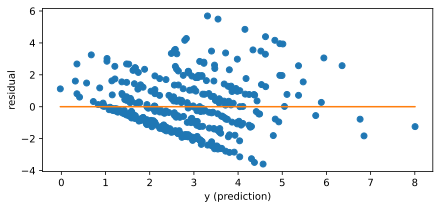

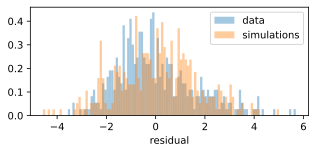

In [ ]:
# plot residuals vs predicted for this

y_mean_pred_final_reg = y_talc-r_final_reg

fig,ax = plt.subplots(figsize=(7,3))
ax.plot(y_mean_pred_final_reg,(r_final_reg + np.random.normal(0,0.1,len(r_final_reg))),"o") # add jitter for visualization
ax.plot(y_mean_pred_final_reg,np.zeros(len(y_talc)),"-")
ax.set_xlabel("y (prediction)")
ax.set_ylabel("residual")
# finding larger or smaller residual values DOES appear to depend upon Y...slightly more negative residuals as predicted alcohol 
# consumption increases

# graphing histogram of residuals to see if they are normally distributed
r_sims_final_reg = np.random.normal(0,np.sqrt(results_final_reg.mse_resid),len(r_final_reg))
fig,ax = plt.subplots(figsize=(5,2))
ax.hist(r_final_reg,100,alpha=0.4,label="data",density=True);
ax.hist(r_sims_final_reg,100,alpha=0.4,label="simulations",density=True);
ax.legend()
ax.set_xlabel("residual")
# the residuals ARE normally distributed; can see that this distribution appears similar to the residual 
# histogram that is generated from the simulated normal model

## Basically, concluded that this is overall the best model to be able to interpret the predictors that are correlated with student alcohol consumption. Now, let's see if the assumptions that we are making in this model are fulfilled, and if it is actually predictive of what we think it's predictive of. 

### Gender and Alcohol Consumption

                            OLS Regression Results                            
Dep. Variable:                   Talc   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     38.39
Date:                Mon, 21 Nov 2022   Prob (F-statistic):           1.46e-09
Time:                        01:15:10   Log-Likelihood:                -812.27
No. Observations:                 395   AIC:                             1629.
Df Residuals:                     393   BIC:                             1636.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2115      0.131     16.819      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Text(0.5, 1.0, 'Male Total Alcohol Consumption')

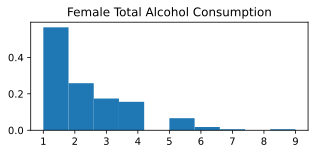

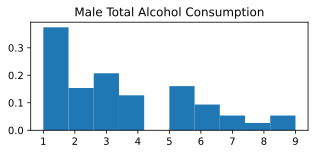

In [ ]:
# simulating alcohol consumption by gender

# actual alcohol consumption regression
alc_gender_reg = sm.OLS(alcohol_df["Talc"],sm.add_constant(alcohol_df["sex"]))
results_alc_gender = alc_gender_reg.fit()
print(results_alc_gender.summary())

# from this, interpretation would be that for an increase of 1 (that is, going from Male to Female) alcohol consumption will increase
# by 1.1842 drinks total per week

# histogram of men and women alcohol consumption (actual data)
fig,ax = plt.subplots(figsize=(5,2))
ax.hist(alcohol_df[alcohol_df["sex"]==0]["Talc"],alpha=1,density=True)
plt.title("Female Total Alcohol Consumption")

fig,ax = plt.subplots(figsize=(5,2))
ax.hist(alcohol_df[alcohol_df["sex"]==1]["Talc"],alpha=1,density=True)
plt.title("Male Total Alcohol Consumption")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     112.4
Date:                Mon, 21 Nov 2022   Prob (F-statistic):           1.40e-25
Time:                        01:15:47   Log-Likelihood:                -4158.5
No. Observations:                2000   AIC:                             8321.
Df Residuals:                    1998   BIC:                             8332.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6430      0.061     43.162      0.0

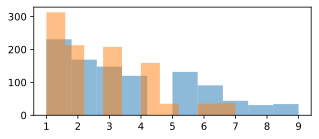

In [ ]:
# simulation of this data, similar proportions to actual ## should do actual??

z_male = np.array([7,5,5,4,4,3,2,1,1])
p_male = z_male/np.sum(z_male)

z_female = np.array([10,7,6,5,1,1,1,0,0])
p_female = z_female/np.sum(z_female)

sim_alc_male = np.random.choice(range(1,10),1000,p = p_male)
sim_alc_female = np.random.choice(range(1,10),1000,p = p_female)

fig,ax = plt.subplots(figsize=(5,2))
ax.hist(sim_alc_male, alpha = 0.5)
ax.hist(sim_alc_female, alpha = 0.5)

# run regression on simulated data
y = np.concatenate([sim_alc_male,sim_alc_female])
X = np.concatenate([np.ones(1000),np.zeros(1000)])

sim_gender_alc = sm.OLS(y,sm.add_constant(X))
results_sim_gender_alc = sim_gender_alc.fit()
print(results_sim_gender_alc.summary())
sim_gender_coef = results_sim_gender_alc.params[1]
print("Generated regression coefficient:", sim_gender_coef)

print("Male mean alcohol consumption:", np.mean(sim_alc_male))
print("Female mean alcohol consumption:", np.mean(sim_alc_female))
print("Difference:", (np.mean(sim_alc_male) - np.mean(sim_alc_female)))

# because this difference between mean alcohol consumption for male and females is equal to the regression coefficient for sex,
# this indicates that the model is indeed telling us what we think it is even though some assumptions are violated

### even though the assumptions are not perfectly met, the regression coefficent a still represents the difference between the mean female and mean male alcohol consumption. therefore, this part of the model can be generalized. also want to run other simulations with slightly different distributions and see if this is still the case

### Travel Time and Alcohol Consumption

In [ ]:
## travel time can take on discrete values 1, 2, 3, 4

# actual alcohol consumption regression using dummy variables
X_traveltime_df = alcohol_df["traveltime"]
X_traveltime_new = pd.get_dummies(X_traveltime_df,drop_first=True)
X_traveltime_new
X_traveltime_numpy = X_traveltime_new.to_numpy()

alc_traveltime_reg = sm.OLS(alcohol_df["Talc"],sm.add_constant(X_traveltime_numpy))
results_alc_traveltime = alc_traveltime_reg.fit()
print(results_alc_traveltime.summary())

X_traveltime_new

                            OLS Regression Results                            
Dep. Variable:                   Talc   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     8.158
Date:                Mon, 21 Nov 2022   Prob (F-statistic):           2.79e-05
Time:                        01:15:51   Log-Likelihood:                -818.69
No. Observations:                 395   AIC:                             1645.
Df Residuals:                     391   BIC:                             1661.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7043      0.121     22.434      0.0

,2,3,4
0,1,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
390,0,0,0
391,1,0,0
392,0,0,0
393,0,1,0


Text(0.5, 1.0, 'Travel Time Over 60 min')

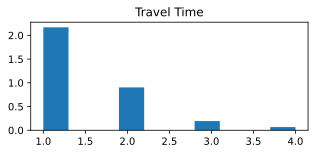

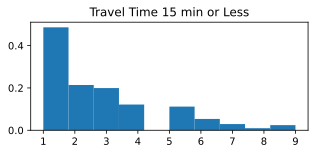

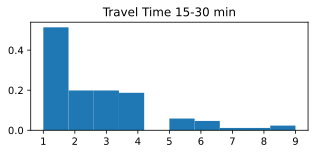

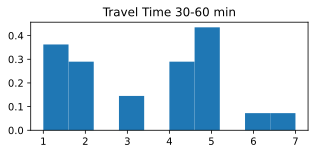

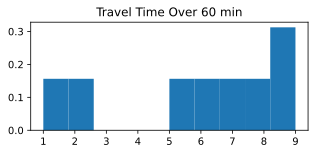

In [ ]:
# graph histogram of travel time
fig,ax = plt.subplots(figsize=(5,2))
ax.hist(alcohol_df["traveltime"],alpha=1,density=True)
plt.title("Travel Time")
# not normally distributed

# histogram of alcohol consumption for each value of travel time
fig,ax = plt.subplots(figsize=(5,2))
ax.hist(alcohol_df[alcohol_df["traveltime"]==1]["Talc"],alpha=1,density=True)
plt.title("Travel Time 15 min or Less")

fig,ax = plt.subplots(figsize=(5,2))
ax.hist(alcohol_df[alcohol_df["traveltime"]==2]["Talc"],alpha=1,density=True)
plt.title("Travel Time 15-30 min")

fig,ax = plt.subplots(figsize=(5,2))
ax.hist(alcohol_df[alcohol_df["traveltime"]==3]["Talc"],alpha=1,density=True)
plt.title("Travel Time 30-60 min")

fig,ax = plt.subplots(figsize=(5,2))
ax.hist(alcohol_df[alcohol_df["traveltime"]==4]["Talc"],alpha=1,density=True)
plt.title("Travel Time Over 60 min")

In [ ]:
# generate simulation

# need to randomly decide their travel time based upon proportions, and then randomly decide based upon this what 
# their alcohol consumption will be

# find proportions
print((alcohol_df["traveltime"].value_counts())/395)

tt_sim_df = pd.DataFrame(data = (np.random.choice([1,2,3,4], size=1000, p=[0.65, 0.27, 0.06, 0.02])), columns = ["traveltime"])
alc_list = []
for tt in tt_sim_df["traveltime"]:
  if tt == 1:
    p_list = np.array([10,5,5,3,3,2,1,1,1])
    alc_consump = np.random.choice(range(1,10), p = (p_list/sum(p_list)))
    alc_list.append(alc_consump)
  elif tt == 2:
    p_list = np.array([12,5,5,4,3,2,1,1,1])
    alc_consump = np.random.choice(range(1,10), p = (p_list/sum(p_list)))
    alc_list.append(alc_consump)
  elif tt == 3:
    p_list = np.array([10,8,6,5,8,12,4,3,1])
    alc_consump = np.random.choice(range(1,10), p = (p_list/sum(p_list)))
    alc_list.append(alc_consump)
  else:
    p_list = np.array([1,1,1,1,1,1,1,1,2])
    alc_consump = np.random.choice(range(1,10), p = (p_list/sum(p_list)))
    alc_list.append(alc_consump)
tt_sim_df["Talc_sim"] = alc_list
tt_sim_df

# visualize simulated data

1    0.650633
2    0.270886
3    0.058228
4    0.020253
Name: traveltime, dtype: float64


,traveltime,Talc_sim
0,1,5
1,1,1
2,1,1
3,2,5
4,1,1
...,...,...
995,1,6
996,1,5
997,1,2
998,1,2


In [ ]:
# run regression with simulated data

# calculate the means of each group and see their difference with tt=1 and then see how this compares to the calculated coefficients in the
# regression done by statsmodels and if it is accurate

X_sim_traveltime_new = pd.get_dummies(tt_sim_df["traveltime"],drop_first=True)
X_traveltime_sim_numpy = X_sim_traveltime_new.to_numpy()

alc_traveltime_sim_reg = sm.OLS(tt_sim_df["Talc_sim"],sm.add_constant(X_sim_traveltime_new))
results_alc_traveltime_sim = alc_traveltime_sim_reg.fit()
print(results_alc_traveltime_sim.summary())

                            OLS Regression Results                            
Dep. Variable:               Talc_sim   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     6.805
Date:                Mon, 21 Nov 2022   Prob (F-statistic):           0.000153
Time:                        01:16:26   Log-Likelihood:                -2216.2
No. Observations:                1000   AIC:                             4440.
Df Residuals:                     996   BIC:                             4460.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1948      0.087     36.821      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# calculate means
mean_tt_1 = np.mean(tt_sim_df[tt_sim_df["traveltime"]==1]["Talc_sim"])
mean_tt_2 = np.mean(tt_sim_df[tt_sim_df["traveltime"]==2]["Talc_sim"])
mean_tt_3 = np.mean(tt_sim_df[tt_sim_df["traveltime"]==3]["Talc_sim"])
mean_tt_4 = np.mean(tt_sim_df[tt_sim_df["traveltime"]==4]["Talc_sim"])
print("Mean for tt=1", mean_tt_1)
print("Mean for tt=2", mean_tt_2)
print("Mean for tt=3", mean_tt_3)
print("Mean for tt=4", mean_tt_4)

print("Difference tt=1 and tt=2", mean_tt_2 - mean_tt_1)
print("Difference tt=1 and tt=3", mean_tt_3 - mean_tt_1)
print("Difference tt=1 and tt=4", mean_tt_4 - mean_tt_1)

# these are equal to the coefficients showing that the coefficients do indeed tell us what we think that they do - that it is the
# mean difference between the alcohol consumption for a student with tt2, tt3, tt4 relative to tt1

Mean for tt=1 3.1948249619482496
Mean for tt=2 3.1760299625468167
Mean for tt=3 4.6
Mean for tt=4 3.769230769230769
Difference tt=1 and tt=2 -0.01879499940143292
Difference tt=1 and tt=3 1.40517503805175
Difference tt=1 and tt=4 0.5744058072825196


### now looking at absences and how they predict alcohol consumption

                            OLS Regression Results                            
Dep. Variable:                   Talc   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     7.707
Date:                Mon, 21 Nov 2022   Prob (F-statistic):            0.00576
Time:                        01:22:38   Log-Likelihood:                -826.84
No. Observations:                 395   AIC:                             1658.
Df Residuals:                     393   BIC:                             1666.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5758      0.122     21.171      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,absences,sim_alc
0,6,2.815858
1,3,7.139019
2,3,2.169597
3,5,2.369546
4,5,-1.097508
...,...,...
995,49,7.347819
996,62,10.133199
997,59,8.038861
998,32,2.986868


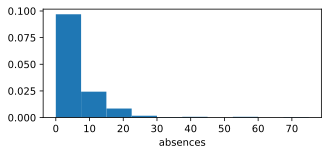

In [ ]:
# real regression
alc_absences_reg = sm.OLS(alcohol_df["Talc"],sm.add_constant(alcohol_df["absences"]))
results_alc_absences = alc_absences_reg.fit()
print(results_alc_absences.summary())
abs_b, abs_a = results_alc_absences.params
sigma_fit_abs = np.sqrt(results_alc_absences.mse_resid)
print(abs_a, abs_b, sigma_fit_abs)

# simulation

# create histogram of absences so that we can analyze the proportion that have each absence
fig,ax = plt.subplots(figsize=(5,2))
ax.hist(alcohol_df["absences"], density=True)
ax.set_xlabel("absences")
print(max(alcohol_df["absences"]))

# generate absences
# total of 1000 observations in simulation, 68% between 0 and 7, 16% from 8-15, 8% 16-23, 8% 23-75
n = 1000
from random import randint
small_abs = [randint(0,7) for x in range(int(0.68*n))]
med_abs = [randint(8,15) for x in range(int(0.16*n))]
big_abs = [randint(16,23) for x in range(int(0.08*n))]
vbig_abs = [randint(23,75) for x in range(int(0.08*n))]
absences = small_abs + med_abs + big_abs + vbig_abs

# generate alcohol consumption based upon this
# make an estimate of a random coefficient that predicts the alcohol consumption based on absences
a_sim = 0.035
b_sim = 3.5
sigma_ep_sim = 2
alc_absences = [(a_sim*x + b_sim + np.random.normal(0,sigma_ep_sim)) for x in absences]
absences_sim_data = {"absences": absences, "sim_alc": alc_absences}
absences_sim_df = pd.DataFrame(data = absences_sim_data)
absences_sim_df

In [ ]:
# now run a regression on this data and see if it works 

alc_absences_simreg = sm.OLS(absences_sim_df["sim_alc"],sm.add_constant(absences_sim_df["absences"]))
results_alc_absences_sim = alc_absences_simreg.fit()
print(results_alc_absences_sim.summary())

# the coefficient is not exact, but it does still show stuff because the constant and the coefficient for absences are close to those 
# that were used to generate the data meaning that they do have true meaning for the model

                            OLS Regression Results                            
Dep. Variable:                sim_alc   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     58.62
Date:                Mon, 21 Nov 2022   Prob (F-statistic):           4.50e-14
Time:                        01:22:43   Log-Likelihood:                -2081.3
No. Observations:                1000   AIC:                             4167.
Df Residuals:                     998   BIC:                             4176.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4726      0.075     46.034      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


## finally, looking at going out and how it predicts alcohol consumption

In [ ]:
## goout can take on discrete values 1, 2, 3, 4, 5

# actual alcohol consumption regression using dummy variables
X_goout_df = alcohol_df["goout"]
X_goout_new = pd.get_dummies(X_goout_df,drop_first=True)
X_goout_new
X_goout_numpy = X_goout_new.to_numpy()

alc_goout_reg = sm.OLS(alcohol_df["Talc"],sm.add_constant(X_goout_numpy))
results_alc_goout = alc_goout_reg.fit()
print(results_alc_goout.summary())

                            OLS Regression Results                            
Dep. Variable:                   Talc   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     19.66
Date:                Mon, 21 Nov 2022   Prob (F-statistic):           9.41e-15
Time:                        01:23:50   Log-Likelihood:                -794.40
No. Observations:                 395   AIC:                             1599.
Df Residuals:                     390   BIC:                             1619.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7826      0.379      4.699      0.0

Text(0.5, 1.0, 'Going out 5 (Very High)')

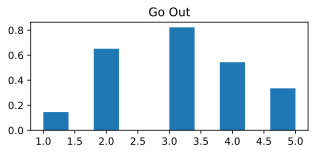

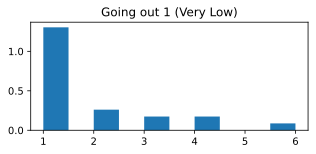

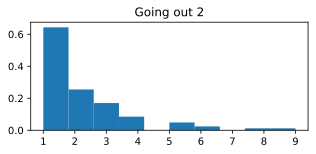

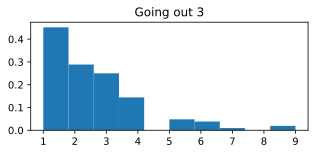

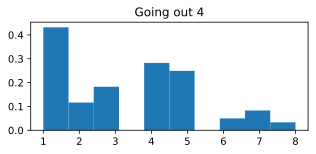

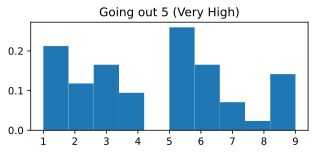

In [ ]:
# graph histogram of going out
fig,ax = plt.subplots(figsize=(5,2))
ax.hist(alcohol_df["goout"],alpha=1,density=True)
plt.title("Go Out")
# normally distributed

# histogram of alcohol consumption for each value of travel time
fig,ax = plt.subplots(figsize=(5,2))
ax.hist(alcohol_df[alcohol_df["goout"]==1]["Talc"],alpha=1,density=True)
plt.title("Going out 1 (Very Low)")

fig,ax = plt.subplots(figsize=(5,2))
ax.hist(alcohol_df[alcohol_df["goout"]==2]["Talc"],alpha=1,density=True)
plt.title("Going out 2")

fig,ax = plt.subplots(figsize=(5,2))
ax.hist(alcohol_df[alcohol_df["goout"]==3]["Talc"],alpha=1,density=True)
plt.title("Going out 3")

fig,ax = plt.subplots(figsize=(5,2))
ax.hist(alcohol_df[alcohol_df["goout"]==4]["Talc"],alpha=1,density=True)
plt.title("Going out 4")

fig,ax = plt.subplots(figsize=(5,2))
ax.hist(alcohol_df[alcohol_df["goout"]==5]["Talc"],alpha=1,density=True)
plt.title("Going out 5 (Very High)")


In [ ]:
# generate simulation

# need to randomly decide their travel time based upon proportions, and then randomly decide based upon this what 
# their alcohol consumption will be

# find proportions
print((alcohol_df["goout"].value_counts())/395)

go_sim_df = pd.DataFrame(data = (np.random.choice([1,2,3,4,5], size=1000, p=[0.06,0.26,0.33,0.22,0.13])), columns = ["goout"])
alc_list = []
for go in go_sim_df["goout"]:
  if go == 1:
    p_list = np.array([10,3,2,2,2,1,0,0,0])
    alc_consump = np.random.choice(range(2,11), p = (p_list/sum(p_list)))
    alc_list.append(alc_consump)
  elif go == 2:
    p_list = np.array([20,8,6,4,3,2,1,1,1])
    alc_consump = np.random.choice(range(2,11), p = (p_list/sum(p_list)))
    alc_list.append(alc_consump)
  elif go == 3:
    p_list = np.array([20,13,11,6,3,2,1,1,1])
    alc_consump = np.random.choice(range(2,11), p = (p_list/sum(p_list)))
    alc_list.append(alc_consump)
  elif go == 3:
    p_list = np.array([20,5,7,9,12,10,4,2,3])
    alc_consump = np.random.choice(range(2,11), p = (p_list/sum(p_list)))
    alc_list.append(alc_consump)
  else:
    p_list = np.array([18,12,16,11,15,20,15,3,10])
    alc_consump = np.random.choice(range(2,11), p = (p_list/sum(p_list)))
    alc_list.append(alc_consump)
go_sim_df["Talc_sim"] = alc_list
go_sim_df

# visualize simulated data

3    0.329114
2    0.260759
4    0.217722
5    0.134177
1    0.058228
Name: goout, dtype: float64


,goout,Talc_sim
0,3,2
1,3,4
2,3,7
3,3,4
4,3,10
...,...,...
995,2,2
996,2,4
997,4,7
998,2,2


In [ ]:
# run regression with simulated data

# calculate the means of each group and see their difference with tt=1 and then see how this compares to the calculated coefficients in the
# regression done by statsmodels and if it is accurate

# X_sim_go_new = pd.get_dummies(go_sim_df["goout"],drop_first=True)
# X_sim_go_numpy = X_sim_go_new.to_numpy()

alc_go_sim_reg = sm.OLS(go_sim_df["Talc_sim"],sm.add_constant((go_sim_df["goout"]).to_numpy()))
results_alc_go_sim = alc_go_sim_reg.fit()
print(results_alc_go_sim.summary())
coef_go_sim = results_alc_go_sim.params[1]
print(coef_go_sim)

                            OLS Regression Results                            
Dep. Variable:               Talc_sim   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     149.6
Date:                Fri, 18 Nov 2022   Prob (F-statistic):           3.81e-32
Time:                        20:45:33   Log-Likelihood:                -2189.7
No. Observations:                1000   AIC:                             4383.
Df Residuals:                     998   BIC:                             4393.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9868      0.207      9.587      0.0

In [ ]:
# calculate means
mean_go_1 = np.mean(go_sim_df[go_sim_df["goout"]==1]["Talc_sim"])
mean_go_2 = np.mean(go_sim_df[go_sim_df["goout"]==2]["Talc_sim"])
mean_go_3 = np.mean(go_sim_df[go_sim_df["goout"]==3]["Talc_sim"])
mean_go_4 = np.mean(go_sim_df[go_sim_df["goout"]==4]["Talc_sim"])
mean_go_5 = np.mean(go_sim_df[go_sim_df["goout"]==5]["Talc_sim"])

print("Mean for go=1", mean_go_1)
print("Mean for go=2", mean_go_2)
print("Mean for go=3", mean_go_3)
print("Mean for go=4", mean_go_4)
print("Mean for go=5", mean_go_5)

# does the coefficient that we get actually show things about the data? YES
slope_1_2 = (mean_go_2 - mean_go_1) / (2-1)
slope_1_3 = (mean_go_3 - mean_go_1) / (3-1)
slope_1_4 = (mean_go_4 - mean_go_1) / (4-1)
slope_1_5 = (mean_go_5 - mean_go_1) / (5-1)
print("Slope between goout = 1 and goout = 2:", slope_1_2)
print("Slope between goout = 1 and goout = 4:", slope_1_4)
print("Calculated coefficent:", coef_go_sim)


# even though the assumptions are violated, the coefficients still give us valuable information about the relationship 
# between alcohol consumption and going out among teens. The calculated coefficient is imperfect but still shows the 
# positive correlation between going out and alcohol consumption and it is within a range that makes sense given the true
# differences in alcohol consumption correlated with going out

Mean for go=1 3.375
Mean for go=2 3.688976377952756
Mean for go=3 3.7457627118644066
Mean for go=4 5.748837209302326
Mean for go=5 5.710743801652892
Slope between goout = 1 and goout = 2: 0.313976377952756
Slope between goout = 1 and goout = 4: 0.7912790697674419
Calculated coefficent: 0.7739336829468864


This code at the bottom is an additional analysis of the univariate correlations between four of the most statistically significant main predictors and alcohol consumption. This is an addition to the collinearity analysis that it done at the beginning of the Python notebook, and represents a more fleshed out method of determining whether two predictors have a correlation - by running univariate regressions with each, and then comparing the coefficients in these univariate regressions and when there are multiple predictors. If the coefficient changes significantly, this indicates collinearity because (for example) if a coefficient that is originally positive and large decreases when another predictor that is found to be positively correlated with the Y variable is added to the regression, an increase in Y previously explained by the first predictor alone is now explained by both predictors, and therefore these two predictors must be positively correlated. 

In [ ]:
# using sex, traveltime, goout, and absences to predict alcohol consumption

data_x1 = alcohol_df[["sex"]]
data_x2 = alcohol_df[["traveltime"]]
data_x3 = alcohol_df[["goout"]]
data_x4 = alcohol_df[["absences"]]
alcohol_df["Talc"] = alcohol_df["Walc"] + alcohol_df["Dalc"]
data_y = alcohol_df[["Talc"]]

# sex is categorical
x_sex = data_x1.sex.unique()
data_x_new1 = pd.get_dummies(data_x1,drop_first=True)

# convert to numpy
x1 = data_x_new1.to_numpy()
x2 = data_x2.to_numpy()
x3 = data_x3.to_numpy()
x4 = data_x4.to_numpy()
y = data_y.to_numpy()

# results with one predictor 
X = sm.add_constant(x1)
model = sm.OLS(y,X)
results = model.fit()
print("a with sex as predictor:")
print(results.params[1])

X = sm.add_constant(x2)
model = sm.OLS(y,X)
results = model.fit()
print("a with traveltime as predictor:")
print(results.params[1])

X = sm.add_constant(x3)
model = sm.OLS(y,X)
results = model.fit()
print("a with goout as predictor:")
print(results.params[1])

X = sm.add_constant(x4)
model = sm.OLS(y,X)
results = model.fit()
print("a with absences as predictor:")
print(results.params[1])

a with sex as predictor:
1.184183463595228
a with traveltime as predictor:
0.4242828464261189
a with goout as predictor:
0.6999471190236712
a with absences as predictor:
0.034387938238548584


In [ ]:
# additional collinearity analysis of the four most statistically significant predictors

x1 = alcohol_df.sex.values
x2 = alcohol_df.traveltime.values
x3 = alcohol_df.goout.values
x4 = alcohol_df.absences.values

print("a1 with goout (x3) and absences (x4) as predictor:")
X = sm.add_constant(np.transpose(np.array([x3,x4])))
model = sm.OLS(y,X)
results = model.fit()
print(results.params[1])

print("a1 with sex (x1) and absences (x4) as predictor:")
X = sm.add_constant(np.transpose(np.array([x1,x4])))
model = sm.OLS(y,X)
results = model.fit()
print(results.params[1])

print("a1 with sex (x1) and goout (x3) as predictor:")
X = sm.add_constant(np.transpose(np.array([x1,x3])))
model = sm.OLS(y,X)
results = model.fit()
print(results.params[1])

print("a1 with sex (x1) and traveltime (x2) as predictor:")
X = sm.add_constant(np.transpose(np.array([x1,x2])))
model = sm.OLS(y,X)
results = model.fit()
print(results.params[1])

print("a1 with traveltime (x2) and goout (x3) as predictor:")
X = sm.add_constant(np.transpose(np.array([x2,x3])))
model = sm.OLS(y,X)
results = model.fit()
print(results.params[1])

print("a1 with traveltime (x2) and absences (x4) as predictor:")
X = sm.add_constant(np.transpose(np.array([x2,x4])))
model = sm.OLS(y,X)
results = model.fit()
print(results.params[1])

print("a1 with traveltime (x2) and sex (x1) as predictor:")
X = sm.add_constant(np.transpose(np.array([x2,x1])))
model = sm.OLS(y,X)
results = model.fit()
print(results.params[1])

print("a1 with goout (x3) and sex (x1) as predictor:")
X = sm.add_constant(np.transpose(np.array([x3,x1])))
model = sm.OLS(y,X)
results = model.fit()
print(results.params[1])

print("a1 with goout (x3) and traveltime (x2) as predictor:")
X = sm.add_constant(np.transpose(np.array([x3,x2])))
model = sm.OLS(y,X)
results = model.fit()
print(results.params[1])

print("a1 with absences (x4) and sex (x1) as predictor:")
X = sm.add_constant(np.transpose(np.array([x4,x1])))
model = sm.OLS(y,X)
results = model.fit()
print(results.params[1])

print("a1 with absences (x4) and traveltime (x2) as predictor:")
X = sm.add_constant(np.transpose(np.array([x4,x2])))
model = sm.OLS(y,X)
results = model.fit()
print(results.params[1])

print("a1 with absences (x4) and goout (x3) as predictor:")
X = sm.add_constant(np.transpose(np.array([x4,x3])))
model = sm.OLS(y,X)
results = model.fit()
print(results.params[1])

a1 with goout (x3) and absences (x4) as predictor:
0.6903502491476777
a1 with sex (x1) and absences (x4) as predictor:
1.2265456764215685
a1 with sex (x1) and goout (x3) as predictor:
1.0720575311354867
a1 with sex (x1) and traveltime (x2) as predictor:
1.1529423847346743
a1 with traveltime (x2) and goout (x3) as predictor:
0.3927188706954631
a1 with traveltime (x2) and absences (x4) as predictor:
0.4294619410686419
a1 with traveltime (x2) and sex (x1) as predictor:
0.3749315036593976
a1 with goout (x3) and sex (x1) as predictor:
0.6634089243922048
a1 with goout (x3) and traveltime (x2) as predictor:
0.6929249018330568
a1 with absences (x4) and sex (x1) as predictor:
0.03951842259487559
a1 with absences (x4) and traveltime (x2) as predictor:
0.03487241707010479
a1 with absences (x4) and goout (x3) as predictor:
0.030133515267796784


**a with sex as predictor:**
1.184183463595228
**does not really change with other predictors**


**a with traveltime as predictor:**
0.4242828464261189
**does not really change with other predictors**


**a with goout as predictor:**
0.6999471190236712
**does not really change with other predictors**

**a with absences as predictor:**
0.034387938238548584
**does not really change with other predictors**

If there had been significant changes in the coefficient, this would indicate collinearity between the two predictors. This does not occur.

There are minimal associations between these main predictors.